# Neural Network Training
### For now, this notebook serves as a basic NN training test. #WIP
### By Xiao Lin
### Reference: Neural Network Example https://github.com/leap-stc/EAEE4000_ML_for_Env_Eng_Sci/blob/main/ClimateBench_tutorials/Neural_Network_example.ipynb

In [45]:
from utils import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

from sklearn.metrics import r2_score

# Data Preprocessing
Split the data into training set and test set, and separate the inputs and the outputs

In [46]:
train_df, test_df = df_prep(file_dir)
train_df

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,58,3,11,0,58
1,19,0,19,0,8
2,38,1,38,0,35
3,59,1,18,0,59
4,46,1,24,3,46
...,...,...,...,...,...
18765,103,3,12,27,103
18766,38,1,19,0,38
18767,51,1,46,0,51
18768,172,6,19,22,172


In [47]:
test_df

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,235,3,158,1,235
1,123,1,35,0,123
2,39,1,39,1,38
3,37,2,15,0,37
4,39,1,39,1,18
...,...,...,...,...,...
4688,60,1,35,0,60
4689,40,1,29,3,40
4690,70,1,70,0,42
4691,52,2,13,0,52


In [48]:
# Separate the inputs and the outputs
X_train_df = train_df.iloc[:, 1:5]
print('<======================= X_train =======================>\n')
print(X_train_df)
y_train_df = train_df.iloc[:, :1]
print('<======================= y_train =======================>\n')
print(y_train_df)
X_test_df = test_df.iloc[:, 1:5]
print('<======================= X_test =======================>\n')
print(X_test_df)
y_test_df = test_df.iloc[:, :1]
print('<======================= y_test =======================>\n')
print(y_test_df)

<======================= X_train =======================>

       CO AQI Value  Ozone AQI Value  NO2 AQI Value  PM2.5 AQI Value
0                 3               11              0               58
1                 0               19              0                8
2                 1               38              0               35
3                 1               18              0               59
4                 1               24              3               46
...             ...              ...            ...              ...
18765             3               12             27              103
18766             1               19              0               38
18767             1               46              0               51
18768             6               19             22              172
18769             1               66              0               90

[18770 rows x 4 columns]
<======================= y_train =======================>

       AQI Value
0          

# Data Normalization
Normalize the input predictors by their mean & std

In [49]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test_truth = y_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(18770, 4) (18770, 1)


# Neural Network Construction
Set the hyperparameters and construct the NN by creating layers

In [50]:
# set hyperparameters
n_neuron       = 256
activation     = 'tanh' #'linear', 'tanh', def my_leaky_relu(x): return tf.nn.leaky_relu(x, alpha=0.01)
num_epochs     = 100
learning_rate  = 0.001
minibatch_size = 16
N_layers       = 3 # number of hidden layers

In [51]:
# Build a neural network from scratch
model = Sequential()

model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(X_train.shape[1],)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 

model.add(Dense(y_train.shape[1],  activation='linear', name="output_layer")) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
#model.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 256)               1280      
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               65792     
                                                                 
 hidden_layer_3 (Dense)      (None, 256)               65792     
                                                                 
 output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________


# Neural Network Training

In [53]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
939/939 [==============================] - 3s 3ms/step - loss: 2317.8306 - val_loss: 867.9911
Epoch 2/100
939/939 [==============================] - 3s 4ms/step - loss: 740.4999 - val_loss: 508.5951
Epoch 3/100
939/939 [==============================] - 3s 3ms/step - loss: 467.3405 - val_loss: 336.4933
Epoch 4/100
939/939 [==============================] - 3s 3ms/step - loss: 298.4847 - val_loss: 196.2780
Epoch 5/100
939/939 [==============================] - 3s 3ms/step - loss: 183.1937 - val_loss: 182.0618
Epoch 6/100
939/939 [==============================] - 3s 3ms/step - loss: 116.1605 - val_loss: 99.2197
Epoch 7/100
939/939 [==============================] - 3s 3ms/step - loss: 66.0697 - val_loss: 46.0650
Epoch 8/100
939/939 [==============================] - 3s 3ms/step - loss: 39.8994 - val_loss: 22.4613
Epoch 9/100
939/939 [==============================] - 3s 3ms/step - loss: 32.4103 - val_loss: 60.3058
Epoch 10/100
939/939 [==============================] - 3s 3m

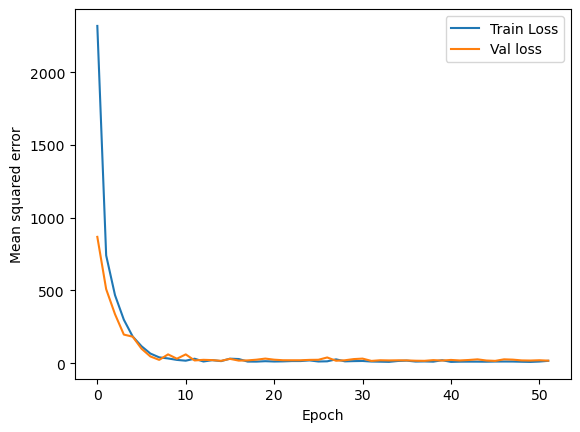

In [54]:
plot_history(history)

In [55]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [56]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'NN_model.h5'))

In [57]:
# reload the saved model
model = load_model(os.path.join(model_path,'NN_model.h5'))

147/147 [==============================] - 0s 910us/step


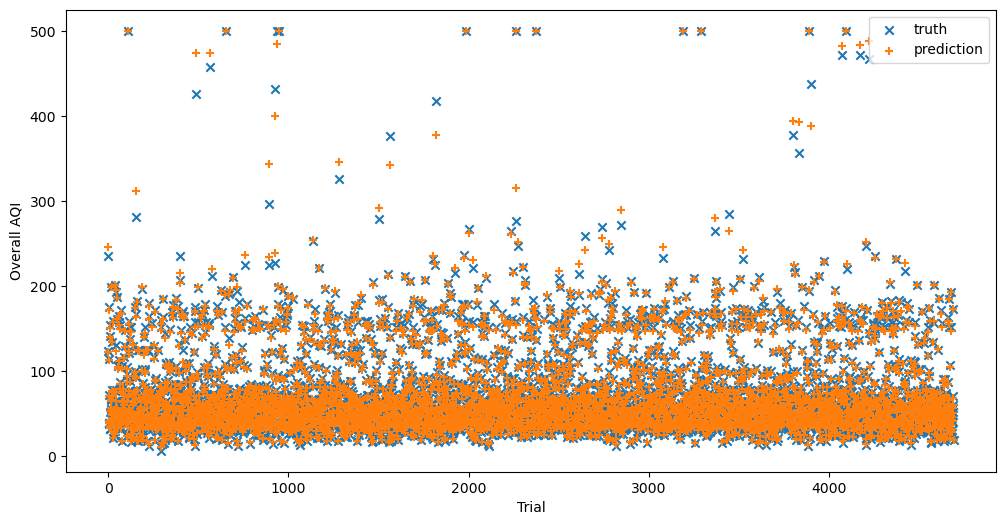

In [58]:
# Generate prediction
y_test_pre = model.predict(X_test)

trial_test = 4693 # There are 4693 test datapoints
trial_array = np.arange(n_test)
#print(n_array)
y_test_truth = np.reshape(y_test_truth, -1)
#print(y_test_truth)
y_test_pre = np.reshape(y_test_pre, -1)
#print(y_test_pre)

fig,ax = plt.subplots(figsize=(12,6))
plt.scatter(trial_array, y_test_truth, marker='x', label='truth')
plt.scatter(trial_array, y_test_pre, marker='+', label='prediction')

ax.legend()
ax.set_xlabel('Trial')
ax.set_ylabel('Overall AQI')

plt.show()

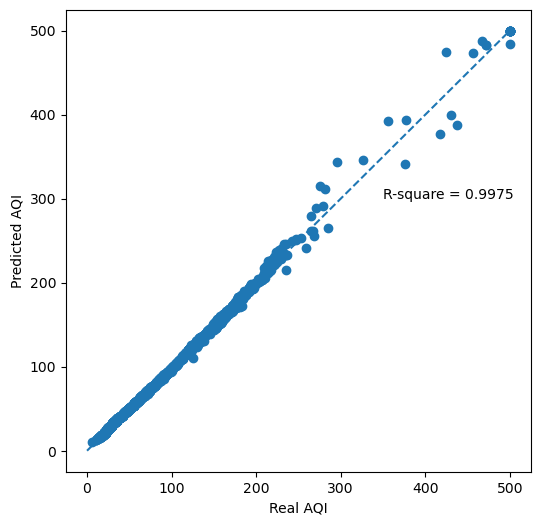

In [66]:
fig,ax = plt.subplots(figsize=(6,6))

r2 = r2_score(y_test_truth, y_test_pre)
plt.text(350, 300, f'R-square = {r2:.4}', fontsize=10)
plt.scatter(y_test_truth, y_test_pre, marker='o')
line_array = np.arange(max(y_test_truth))
plt.plot(line_array, line_array, linestyle='dashed')
ax.set_xlabel('Real AQI')
ax.set_ylabel('Predicted AQI')

plt.show()